<h1><center> <font color='black'> Business Data Analytics - Practice Session_12 </font></center></h1>
<h2><center> <font color='black'>  Knowledge Graphs (KG)</font></center></h3>
<h2><center> <font color='black'> University of Tartu - Spring 2020</font></center></h3>

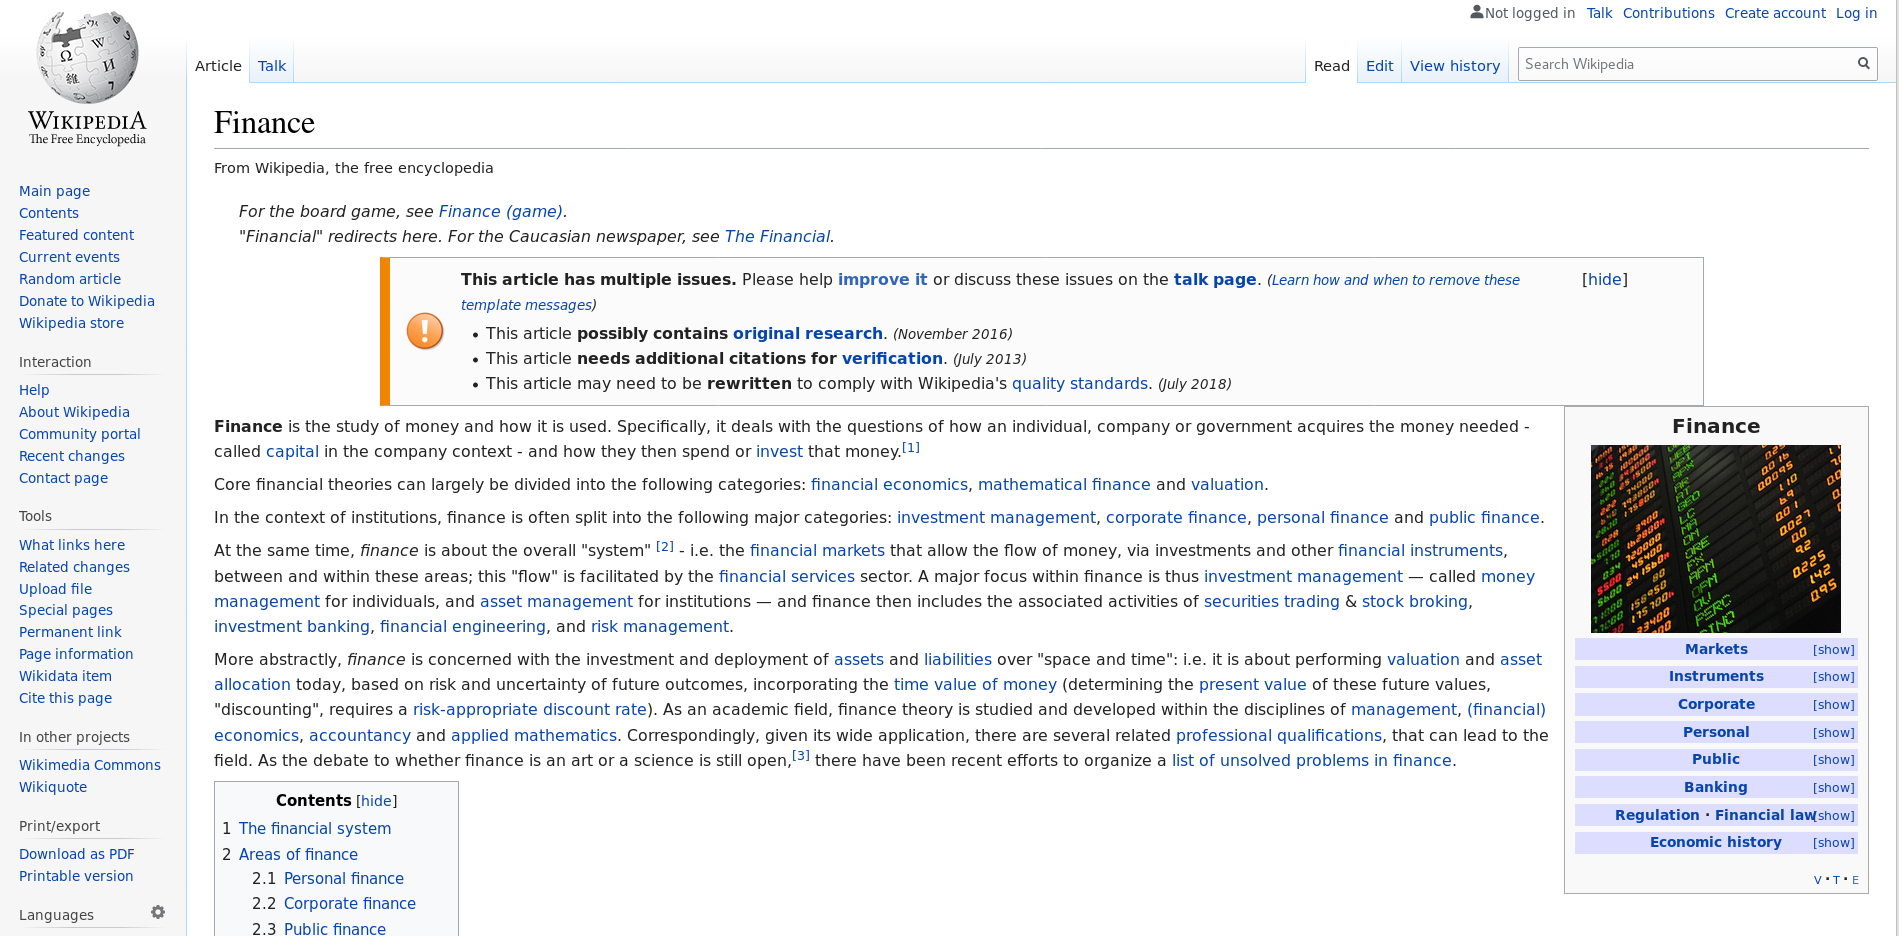

In [0]:
from IPython.display import Image
Image(filename='wiki.png')

## Introduction

* **Finance wkiki** has quite a lot of information there! We have `text`, `tons of hyperlinks`, and even an `audio clip`. That’s a lot of relevant and potentially useful information on a single page. The possibilities of putting this into a use case are endless.

* However, there is a slight problem. This is not an ideal source of data to feed to our machines. Not in its current form anyway.

* Can we find a way to make this text data readable for machines? Essentially, **can we transform this text data into something that can be used by the machines and also can be interpreted easily by us?**

* **Yes, we can!** We can do it with the help of **Knowledge Graphs (KG)**, one of the most fascinating concepts in data science.



## Table of Contents

* What is a Knowledge Graph?
* How to Represent Knowledge in a Graph?
    * Sentence Segmentation
    * Entities Extraction
    * Relations Extraction
* Build a Knowledge Graph from Text Data
* Clustering and Classification using Knowledge Graph Embeddings


### What is a Knowledge Graph?

* Let’s get one thing out of the way – we will see the term **graphs** a lot in this article. We do not mean bar charts, pie charts, and line plots when I say graphs. Here, **we are talking about interconnected `entities` which can be people, locations, organizations, or even an event.**

* We can define a `graph` as a set of **nodes** and **edges.**

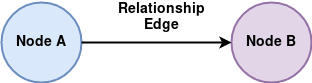

In [0]:
Image(filename='lab.png')

* Node **A** and Node **B** here are two different `entities`. These nodes are connected by an **edge** that represents the `relationship` between the two nodes. Now, this is the smallest knowledge graph we can build – it is also known as a `triple.`

* Knowledge Graph’s come in a variety of shapes and sizes. For example, the knowledge graph of Wikidata had 59,910,568 nodes by October 2019.

### How to Represent Knowledge in a Graph?

* Before we get started with building Knowledge Graphs, it is important to understand how information or knowledge is `embedded` in these graphs.

* Let me explain this using an example. If `Node A = Putin` and `Node B = Russia`, then it is quite likely that the `edge would be “president of”:`

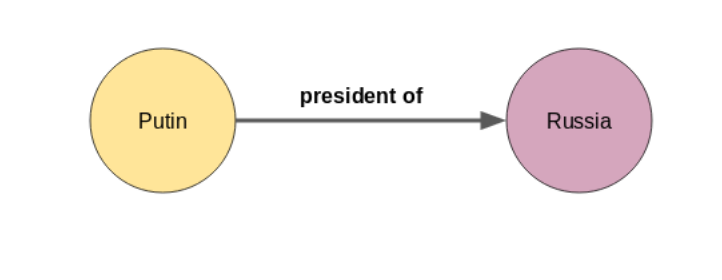

In [0]:
Image(filename='lab2.png')

* **A node or an entity** can have multiple relations as well. Putin is not only the President of Russia, he also worked for the `Soviet Union’s security agency, KGB.` But how do we incorporate this new information about Putin in the knowledge graph above?

* It’s actually pretty simple. `Just add one more node` for the new entity, KGB:

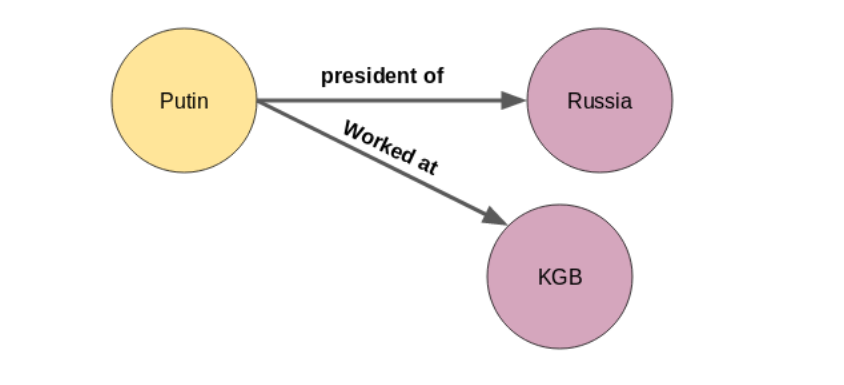

In [0]:
Image(filename='lab3.png')

* The new relationships can emerge not only from the first node but from any node in a knowledge graph as shown below:

* Identifying the entities and the relation between them is not a difficult task for us. However, `manually building a knowledge graph is not scalable.` Nobody is going to go through thousands of documents and extract all the entities and the relations between them!

* That’s why machines are more suitable to perform this task as going through even hundreds or thousands of documents is child’s play for them. But then there is another challenge – machines do not understand `natural language.` This is where **Natural Language Processing (NLP)** comes into the picture.

* To build a knowledge graph from the `text,` it is important to make our machine understand natural language. This can be done by using NLP techniques such as `sentence segmentation, dependency parsing, parts of speech tagging, and entity recognition.` Let’s discuss these in a bit more detail.

### Sentence Segmentation

* The first step in building a knowledge graph is `to split the text document or article into sentences.` Then, we will shortlist only those sentences in which there is exactly `1 subject and 1 object.` Let’s look at a sample text below:

“Indian tennis player Sumit Nagal moved up six places from 135 to a career-best 129 in the latest men’s singles ranking. The 22-year-old recently won the ATP Challenger tournament. He made his Grand Slam debut against Federer in the 2019 US Open. Nagal won the first set.”

* Let’s split the paragraph above into sentences:

    * Indian tennis player Sumit Nagal moved up six places from 135 to a career-best 129 in the latest men’s singles ranking
    * The 22-year-old recently won the ATP Challenger tournament
    * He made his Grand Slam debut against Federer in the 2019 US Open
    * Nagal won the first set

* Out of these four sentences, `we will shortlist the second and the fourth sentences` because each of them contains `1 subject and 1 object.` In the second sentence, **22-year-old** is the subject and the object is **ATP Challenger tournament**. In the fourth sentence, the subject is **Nagal** and **first set** is the object:

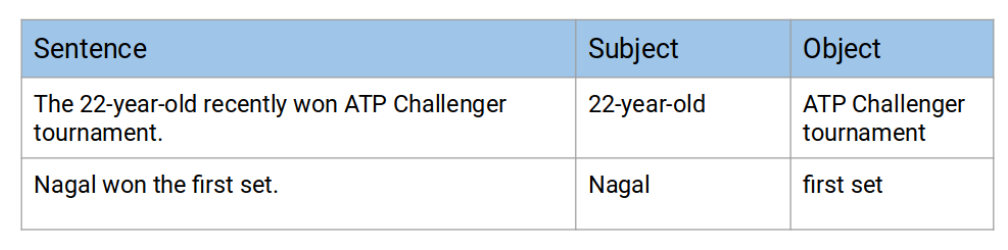

In [0]:
Image(filename='lab4.png')

### Entities (nodes) Extraction

* The extraction of a single word entity from a sentence is not a tough task. We can easily do this with the help of `parts of speech (POS) tags.` The `nouns and the proper nouns would be our entities.`

* However, when an entity spans across multiple words, then POS tags alone are not sufficient. We need to parse the dependency tree of the sentence. You can read more about dependency parsing in the following article.

    * Introduction to Information Extraction using Python and spaCy

* Let’s get the dependency tags for one of the shortlisted sentences. we will use the popular spaCy library for this task:

In [0]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [0]:
import spacy

# nlp 
nlp = spacy.load('en_core_web_sm')

# corpus
doc = nlp("The 22-year-old recently won ATP Challenger tournament.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

The ... det
22-year ... npadvmod
- ... punct
old ... nsubj
recently ... advmod
won ... ROOT
ATP ... compound
Challenger ... compound
tournament ... dobj
. ... punct


 * The subject **(nsubj)** in this sentence as per the dependency parser is `old`. That is not the desired entity. We wanted to extract `22-year-old` instead.

* The dependency tag of `22-year` is **amod** which means it is `a modifier` of `old`. Hence, we should define a rule to extract such entities.


* The rule can be something like this — `extract the subject/object along with its modifiers and also extract the punctuation marks between them.`


* But then look at the object `(dobj)` in the sentence. It is just **tournament** instead of **ATP Challenger tournament**. Here, we don’t have the modifiers but compound words.


* **Compound words** are those words that collectively form a new term with a different meaning. Therefore, we can update the above rule to ⁠— `extract the subject/object along with its modifiers, compound words and also extract the punctuation marks between them.`


* In short, we will use `dependency parsing` to extract entities.


### Extract Relations

* Entity extraction is half the job done. To build a knowledge graph, we need `edges` to connect the nodes (entities) to one another. `These edges are the relations between a pair of nodes.`


* Let’s go back to the example in the last section. We shortlisted a couple of sentences to build a knowledge graph:

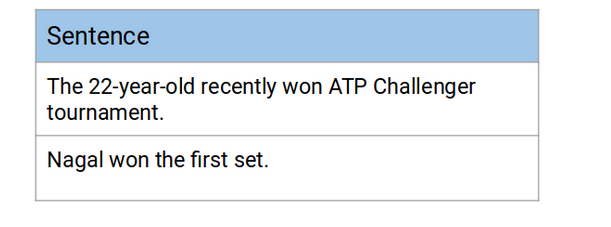

In [0]:
Image(filename='lab5.png')

* Can you guess the relation between the `subject and the object` in these two sentences?

* Both sentences have the same relation – **won**. Let’s see how these relations can be extracted. We will again use dependency parsing:
    

In [0]:
doc = nlp("Nagal won the first set.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Nagal ... nsubj
won ... ROOT
the ... det
first ... amod
set ... dobj
. ... punct


* **To extract the relation,** we have to find the `ROOT` of the sentence (which is also the `verb` of the sentence). Hence, the relation extracted from this sentence would be **won**.

* Finally, the knowledge graph from these two sentences will be like this:

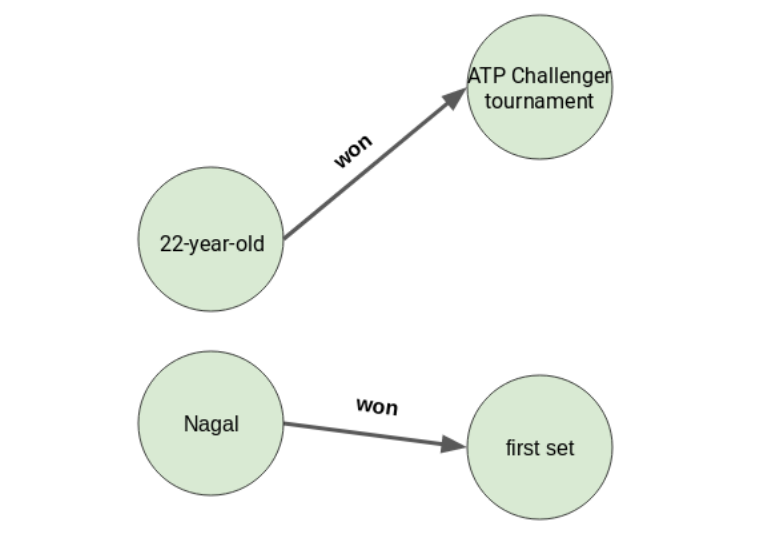

In [0]:
Image(filename='lab6.png')

### Build a Knowledge Graph from Text Data

* We will build a `knowledge graph` from scratch by using the `text from a set of movies and films related to Wikipedia articles.` Each of these sentences contains exactly `two entities – one subject and one object.`

In [0]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

#### Read Data



In [0]:
# Read the CSV file containing the Wikipedia sentences:
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [0]:
# Let’s inspect a few sample sentences
candidate_sentences['sentence'].sample(5)

991                                                             the game was released on september 6, 2019.
1564                                 the first odia talkie sita bibaha  came from mohan sunder deb goswami.
1135    skbh productions next film will be shikshanachya aaicha gho, a remake directed by mahesh manjrekar.
4296                                                               eggers merely directs us to look inside.
2506                                                     the fourth generation also returned to prominence.
Name: sentence, dtype: object

In [0]:
# define our document
doc = nlp("the drawdown process is governed by astm standard d823")

# extract tokens from doc
for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... amod
d823 ... pobj


* Perfect! There is only one subject `(process)` and only one object `(standard)`. You can check for other sentences in a similar manner.



#### Entity Pairs Extraction


* To build a knowledge graph, the most important things are the nodes and the edges between them.


* These nodes are going to be the `entities` that are present in the Wikipedia sentences. `Edges` are the relationships connecting these entities to one another. We will extract these elements in an unsupervised manner, i.e., we will use the `grammar of the sentences.`


* The main idea is to go through a sentence and extract the subject and the object as and when they are encountered.

* So, we have created a function below to `extract the subject and the object (entities)` from a sentence

In [0]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

* Let me explain the code chunks in the function above:

1. Chunk 1:
    * we defined a few empty variables in this chunk. `prv_tok_dep` and `prv_tok_text` will hold the `dependency tag` of the previous word in the sentence and that previous word itself, respectively. `prefix and modifier` will hold the text that is associated with the `subject or the object.`

2. Chunk 2:
    * Next, we will loop through the tokens in the sentence. We will first check if the token is a punctuation mark or not. If yes, then we will ignore it and move on to the next token. If the token is a part of a compound word (dependency tag = “compound”), we will keep it in the prefix variable. A compound word is a combination of multiple words linked to form a word with a new meaning (example – “Football Stadium”, “animal lover”).

    * As and when we come across a subject or an object in the sentence, we will add this prefix to it. We will do the same thing with the modifier words, such as “nice shirt”, “big house”, etc.

3. Chunk 3:
    * Here, if the token is the subject, then it will be captured as the first entity in the ent1 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will be reset.

4. Chunk 4:
    * Here, if the token is the object, then it will be captured as the second entity in the ent2 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will again be reset.

5. Chunk 5:
    *Once we have captured the subject and the object in the sentence, we will update the previous token and its dependency tag.


* Let’s test this function on a sentence:

In [0]:
get_entities("the film had 200 patents")

['film', '200  patents']

* Great, it seems to be working as planned. In the above sentence, `film` is the subject and `200 patents` is the object.

* Now we can use this function to extract these entity pairs for all the sentences in our data:

In [0]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:37<00:00, 116.28it/s]


* The list entity_pairs contains all the subject-object pairs from the Wikipedia sentences. Let’s have a look at a few of them:

In [0]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['', 'military  arrest'],
 ['train', 'vuk'],
 ['telepath', 'gallio'],
 ['singer', 'men']]

* As you can see, there are a few pronouns in these entity pairs such as `we`, `it`, `she`, etc. We’d like to have proper nouns or nouns instead. Perhaps we can further improve the get_entities( ) function to filter out pronouns. For the time being, let’s leave it as it is and move on to the relation extraction part.


#### Relation / Predicate Extraction

* This is going to be a very interesting aspect of this article. Our hypothesis is that the predicate is actually the main verb in a sentence.

* For example, in the sentence – `Sixty Hollywood musicals were released in 1929`, the verb is `released in` and this is what we are going to use as the predicate for the triple generated from this sentence.

* The function below is capable of capturing such predicates from the sentences. Here, we have used spaCy’s rule-based matching:

In [0]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

* The pattern defined in the function tries to find the ROOT word or the main verb in the sentence. Once the ROOT is identified, then the pattern checks whether it is followed by a preposition (‘prep’) or an agent word. If yes, then it is added to the ROOT word.

* Let me show you a glimpse of this function:

In [0]:
get_relation("John completed the task")

'completed'

In [0]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:32<00:00, 132.18it/s]


Let’s take a look at the most frequent relations or predicates that we have just extracted:

In [0]:
pd.Series(relations).value_counts()[:50]

is               370
was              297
released on       87
include           73
were              71
are               71
released          40
's                38
composed by       35
has               31
have              31
became            31
become            29
released in       27
included          26
called            22
produced          22
considered        20
had               20
made              20
be                18
been              18
scheduled         17
used              17
stars             16
directed by       16
written by        15
produced by       14
set               14
hired             14
wrote             14
went              13
introduced in     13
received          13
wanted            12
began             11
won               11
began in          11
gave              10
sold              10
features          10
known as           9
used in            9
shot in            9
opened             9
produced in        9
directed           9
reported     

* It turns out that relations like `A is B` and `A was B` are the most common relations. However, there are quite a few relations that are more associated with the overall theme – “the ecosystem around movies”. Some of the examples are `composed by`, `released in`, `produced`, `written by` and a few more.


#### Build a Knowledge Graph

* We will finally create a knowledge graph from the extracted entities `(subject-object pairs)` and the `predicates` (relation between entities).

* Let’s create a `dataframe of entities and predicates:`

In [0]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df

,source,target,edge
0,connie,own,decides
1,later woman,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,outside cult,him,wails with
...,...,...,...
4313,confidencial,negatively film,responded
4314,le parisien,five star rating,gave
4315,museum collection,"37,000 film titles",includes
4316,predecessor,historical film 1946,was


* Next, we will use the networkx library to create a network from this dataframe. The nodes will represent the entities and the edges or connections between the nodes will represent the relations between the nodes.


* It is going to be a directed graph. In other words, the relation between any connected node pair is not two-way, it is only from one node to another. For example, `John eats pasta`:

 

In [0]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

* Let’s plot the network:

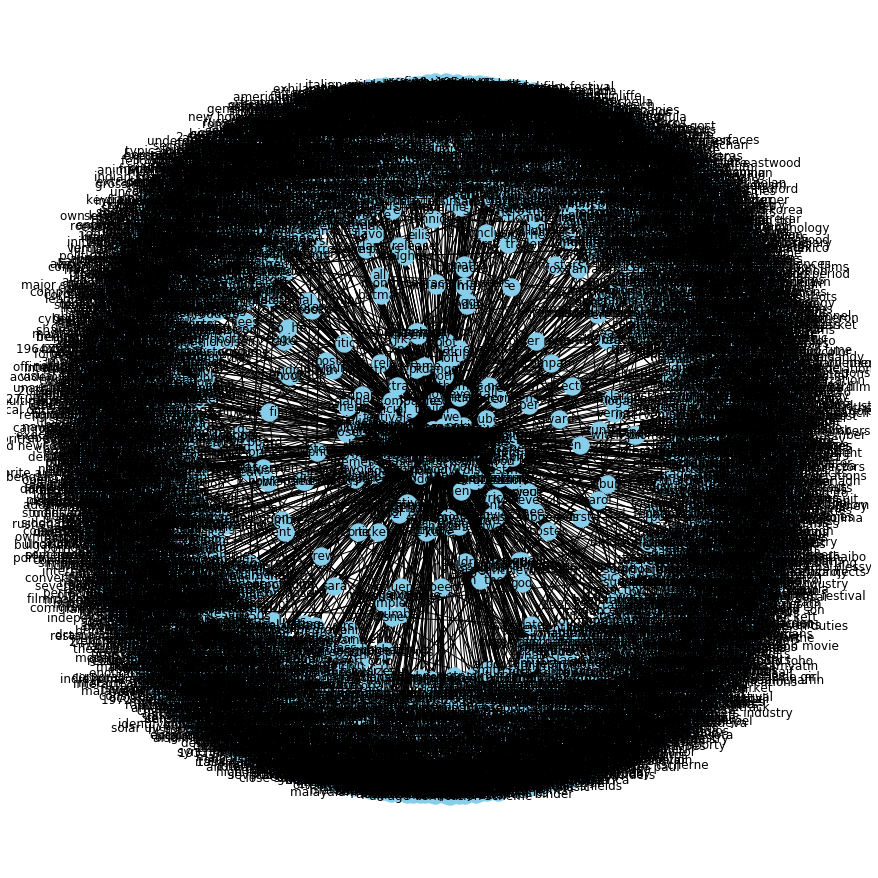

In [0]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

* Well, this is not exactly what we were hoping for (still looks quite a sight though!).

* It turns out that we have created a graph with all the relations that we had. It becomes really hard to visualize a graph with these many relations or predicates.

* So, it’s advisable to use only a few important relations to visualize a graph. I will take one relation at a time. Let’s start with the relation “composed by”:

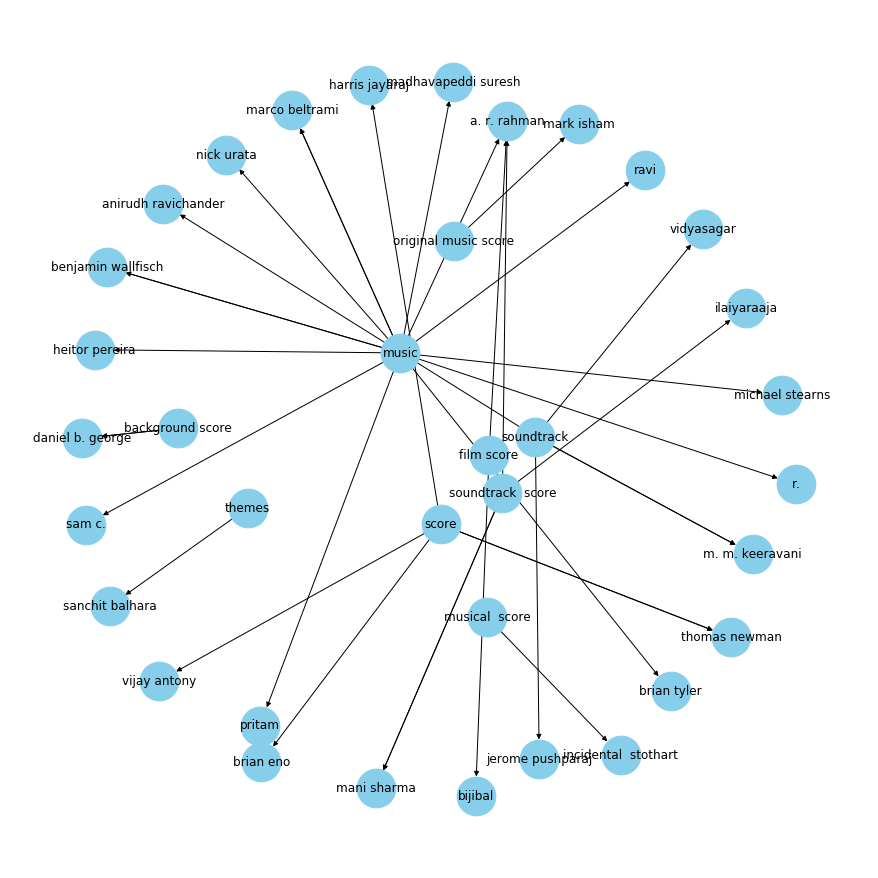

In [0]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

* That’s a much cleaner graph. Here the arrows point towards the composers. For instance, A.R. Rahman, who is a renowned music composer, has entities like “soundtrack score”, “film score”, and “music” connected to him in the graph above.

* Let’s check out a few more relations.

* Since writing is an important role in any movie, I would like to visualize the graph for the “written by” relation:

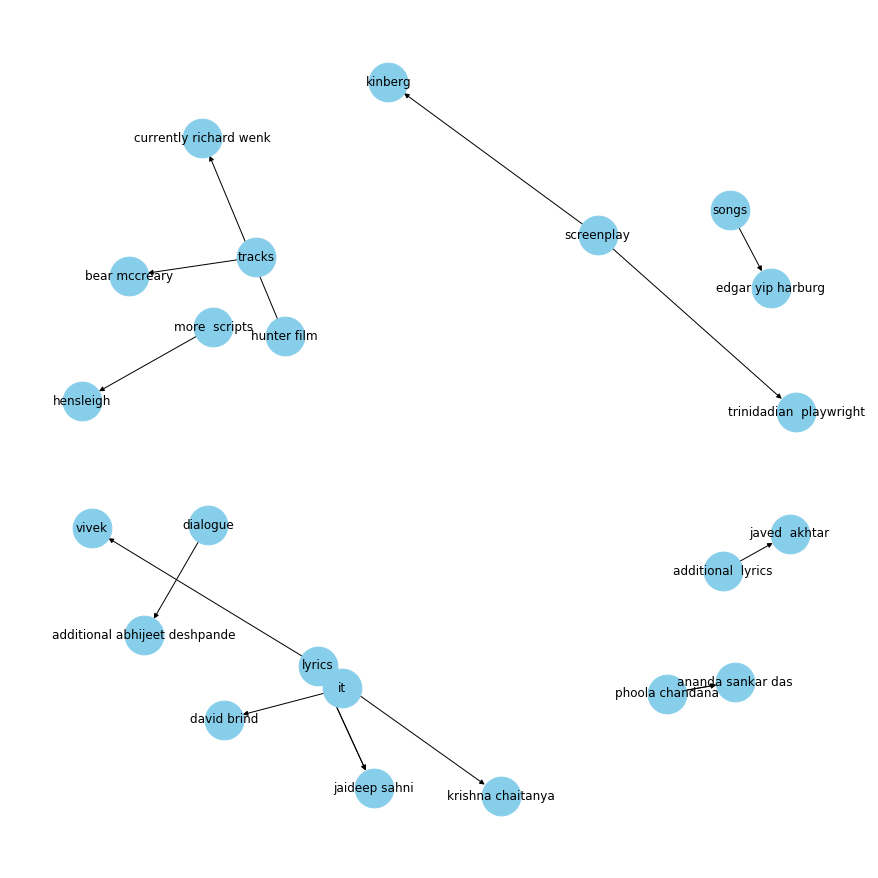

In [0]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

* Awesome! This `knowledge graph` is giving us some extraordinary information. Guys like Javed Akhtar, Krishna Chaitanya, and Jaideep Sahni are all famous lyricists and this graph beautifully captures this relationship.

* Let’s see the knowledge graph of another important predicate, i.e., the `released in`:

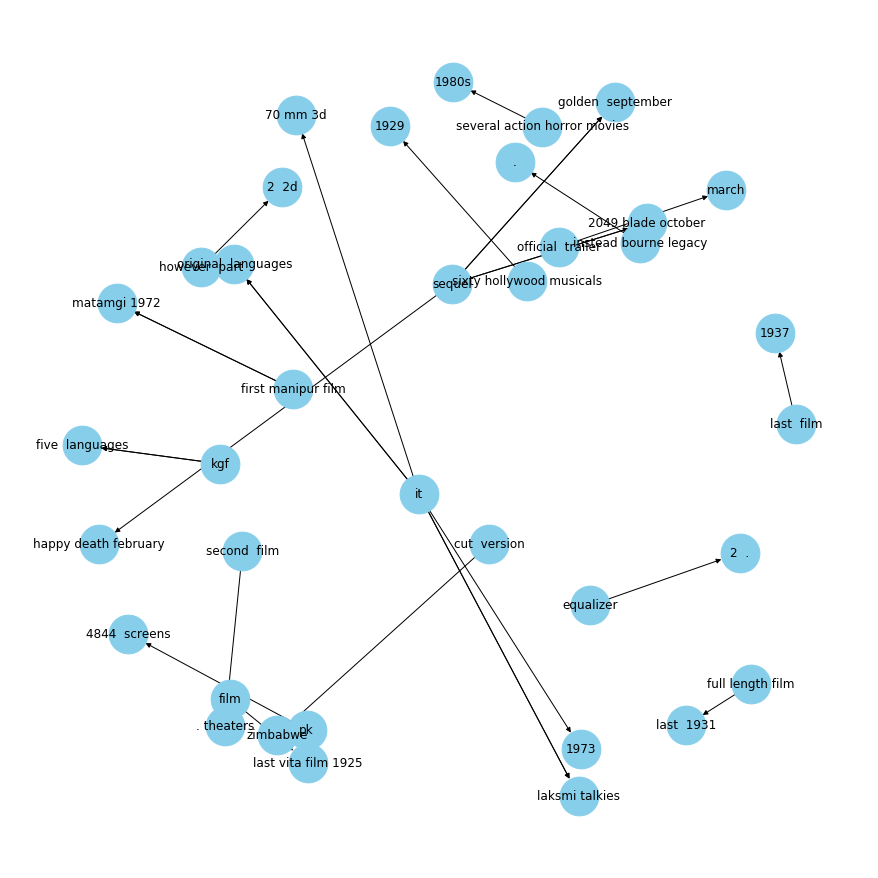

In [0]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

* I can see quite a few interesting information in this graph. For example, look at this relationship – “several action horror movies released in the 1980s” and “pk released on 4844 screens”. These are facts and it shows us that we can mine such facts from just text. That’s quite amazing!



---
# Clustering and Classification using Knowledge Graph Embeddings
---

* In this part we will explore how to use the `knowledge embeddings` generated by a graph of international football matches (since the 19th century) in `clustering and classification tasks.`

* **Knowledge graph embeddings** are typically used for missing link prediction and knowledge discovery, but they can also be used for entity clustering, entity disambiguation, and other downstream tasks. The embeddings are a form of representation learning that allow linear algebra and machine learning to be applied to knowledge graphs, which otherwise would be difficult to do.


* In this part we will cover:

1. Creating the knowledge graph (i.e. triples) from a tabular dataset of football matches
2. Training the `ComplEx embedding model` on those triples
3. Evaluating the quality of the embeddings on a validation set
4. Clustering the embeddings, comparing to the natural clusters formed by the geographical continents
5. Applying the embeddings as features in classification task, to predict match results
6. Evaluating the predictive model on a out-of-time test set, comparing to a simple baseline

* We will show that knowledge embedding clusters manage to capture implicit geographical information from the graph and that they can be a useful feature source for a downstream machine learning classification task, significantly increasing accuracy from the baseline.

---

## Requirements

* We will use a Knowledge graph package called **AmpliGraph**. 

(http://docs.ampligraph.org/en/latest/install.html).



In [0]:
%%capture
!pip install ampligraph

import numpy as np
import pandas as pd
import ampligraph

ampligraph.__version__

## Dataset

We will use the [International football results from 1872 to 2019](https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017) available at Kaggle (public domain). It contains over 40 thousand international football matches. Each row contains the following information:
1. Match date
2. Home team name
3. Away team name
4. Home score (goals including extra time)
5. Away score (goals including extra time)
6. Tournament (whether it was a friendly match or part of a tournament)
7. City where match took place
8. Country where match took place
9. Whether match was on neutral grounds

This dataset comes in a tabular format, therefore we will need to construct the knowledge graph ourselves.

In [0]:
import requests
url = 'https://ampligraph.s3-eu-west-1.amazonaws.com/datasets/football_graph.csv'
open('football_results.csv', 'wb').write(requests.get(url).content)

3033782

In [0]:
df = pd.read_csv("football_results.csv").sort_values("date")

In [0]:
df.isna().sum()

date          0
home_team     0
away_team     0
home_score    2
away_score    2
tournament    0
city          0
country       0
neutral       0
dtype: int64

Dropping matches with unknown score:

In [0]:
df = df.dropna()

The training set will be from 1872 to 2014, while the test set will be from 2014 to present date. Note that a temporal test set makes any machine learning task harder compared to a random shuffle.

In [0]:
df["train"] = df.date < "2014-01-01"

In [0]:
df.train.value_counts()

True     35714
False     5057
Name: train, dtype: int64

## Knowledge graph creation
We are going to create a knowledge graph from scratch based on the match information. The idea is that each match is an entity that will be connected to its participating teams, geography, characteristics, and results. 

The objective is to generate a new representation of the dataset where each data point is an triple in the form:

    <subject, predicate, object>
    
First we need to create the entities (subjects and objects) that will form the graph. We make sure teams and geographical information result in different entities (e.g. the Brazilian team and the corresponding country will be different).

In [0]:
# Entities naming
df["match_id"] = df.index.values.astype(str)
df["match_id"] =  "Match" + df.match_id
df["city_id"] = "City" + df.city.str.title().str.replace(" ", "")
df["country_id"] = "Country" + df.country.str.title().str.replace(" ", "")
df["home_team_id"] = "Team" + df.home_team.str.title().str.replace(" ", "")
df["away_team_id"] = "Team" + df.away_team.str.title().str.replace(" ", "")
df["tournament_id"] = "Tournament" + df.tournament.str.title().str.replace(" ", "")
df["neutral"] = df.neutral.astype(str)

Then, we create the actual triples based on the relationship between the entities. We do it only for the triples in the training set (before 2014).

In [0]:
triples = []
for _, row in df[df["train"]].iterrows():
    # Home and away information
    home_team = (row["home_team_id"], "isHomeTeamIn", row["match_id"])
    away_team = (row["away_team_id"], "isAwayTeamIn", row["match_id"])
    
    # Match results
    if row["home_score"] > row["away_score"]:
        score_home = (row["home_team_id"], "winnerOf", row["match_id"])
        score_away = (row["away_team_id"], "loserOf", row["match_id"])
    elif row["home_score"] < row["away_score"]:
        score_away = (row["away_team_id"], "winnerOf", row["match_id"])
        score_home = (row["home_team_id"], "loserOf", row["match_id"])
    else:
        score_home = (row["home_team_id"], "draws", row["match_id"])
        score_away = (row["away_team_id"], "draws", row["match_id"])
    home_score = (row["match_id"], "homeScores", np.clip(int(row["home_score"]), 0, 5))
    away_score = (row["match_id"], "awayScores", np.clip(int(row["away_score"]), 0, 5))
    
    # Match characteristics
    tournament = (row["match_id"], "inTournament", row["tournament_id"])
    city = (row["match_id"], "inCity", row["city_id"])
    country = (row["match_id"], "inCountry", row["country_id"])
    neutral = (row["match_id"], "isNeutral", row["neutral"])
    year = (row["match_id"], "atYear", row["date"][:4])
    
    triples.extend((home_team, away_team, score_home, score_away, 
                    tournament, city, country, neutral, year, home_score, away_score))

Note that we treat some literals (year, neutral match, home score, away score) as discrete entities and they will be part of the final knowledge graph used to generate the embeddings. We limit the number of score entities by clipping the score to be at most 5.

Below we can see visualise a subset of the graph related to the infamous [Maracanazo](https://en.wikipedia.org/wiki/Uruguay_v_Brazil_(1950_FIFA_World_Cup)):


![Football graph](https://drive.google.com/uc?id=1sN-Iil4xAKbQXICTl4YlVATqN0FfGpcr)

The whole graph related to this match can be summarised by the triples below:

In [0]:
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
triples_df[(triples_df.subject=="Match3129") | (triples_df.object=="Match3129")]

,subject,predicate,object
34419,TeamBrazil,isHomeTeamIn,Match3129
34420,TeamUruguay,isAwayTeamIn,Match3129
34421,TeamBrazil,loserOf,Match3129
34422,TeamUruguay,winnerOf,Match3129
34423,Match3129,inTournament,TournamentFifaWorldCup
34424,Match3129,inCity,CityRioDeJaneiro
34425,Match3129,inCountry,CountryBrazil
34426,Match3129,isNeutral,False
34427,Match3129,atYear,1950
34428,Match3129,homeScores,1


In [0]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(triples_df, "subject", "object", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

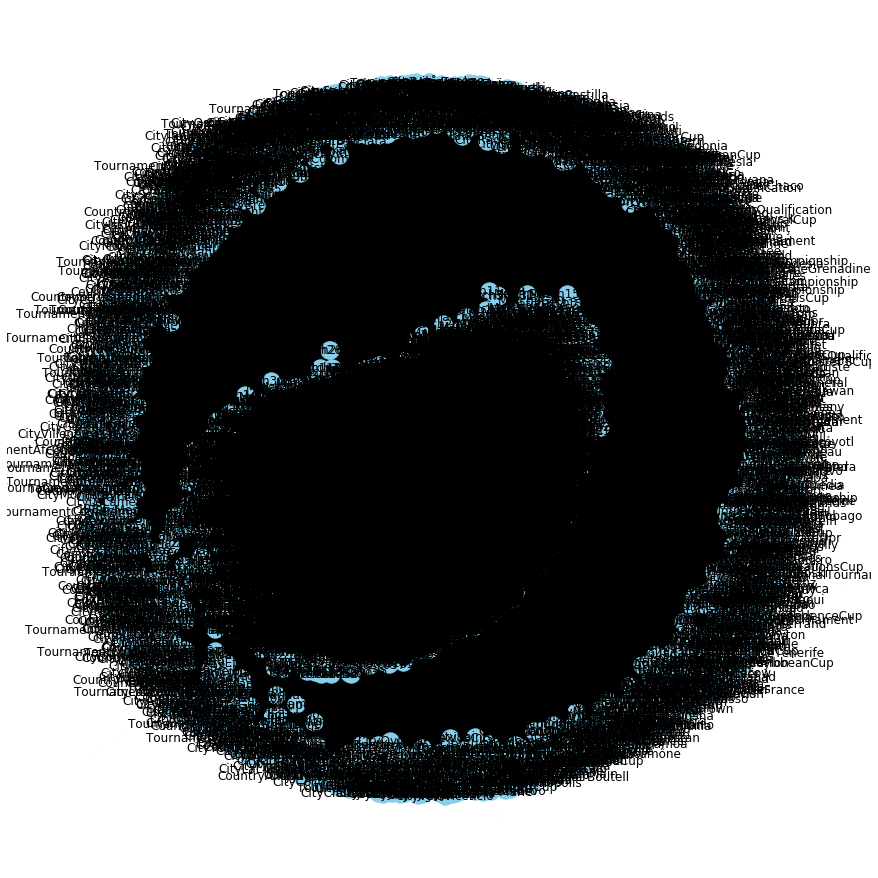

In [0]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

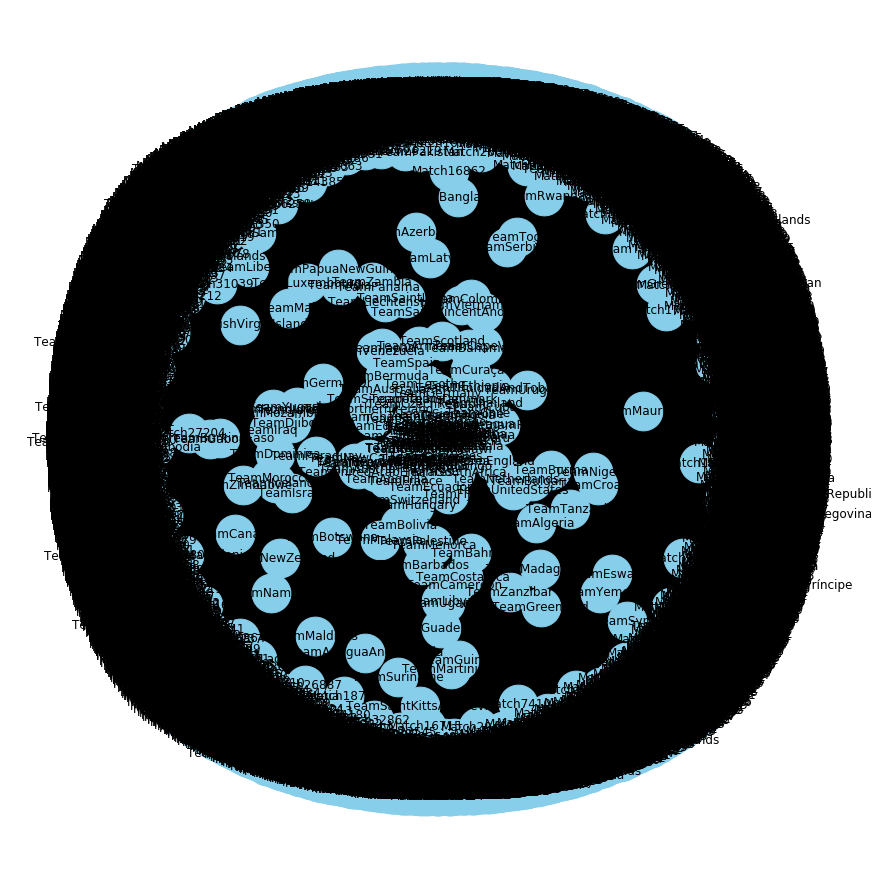

In [0]:
G=nx.from_pandas_edgelist(triples_df[triples_df['predicate']=="isHomeTeamIn"], "subject", "object",  
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [0]:


G=nx.from_pandas_edgelist(triples_df[triples_df['predicate']=="atYear"], "subject", "object",  
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

## Training knowledge graph embeddings

We split our training dataset further into training and validation, where the new training set will be used to the knowledge embedding training and the validation set will be used in its evaluation. The test set will be used to evaluate the performance of the classification algorithm built on top of the embeddings.

What differs from the standard method of randomly sampling N points to make up our validation set is that our data points are two entities linked by some relationship, and we need to take care to ensure that all entities are represented in train and validation sets by at least one triple.

To accomplish this, AmpliGraph provides the [`train_test_split_no_unseen`](https://docs.ampligraph.org/en/latest/generated/ampligraph.evaluation.train_test_split_no_unseen.html#train-test-split-no-unseen) function.

In [0]:
from ampligraph.evaluation import train_test_split_no_unseen 

X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=10000)

In [0]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_valid.shape)

Train set size:  (382854, 3)
Test set size:  (10000, 3)


AmpliGraph has implemented [several Knowledge Graph Embedding models](https://docs.ampligraph.org/en/latest/ampligraph.latent_features.html#knowledge-graph-embedding-models) (TransE, ComplEx, DistMult, HolE), but to begin with we're just going to use the [ComplEx](https://docs.ampligraph.org/en/latest/generated/ampligraph.latent_features.ComplEx.html#ampligraph.latent_features.ComplEx) model, which is known to bring state-of-the-art predictive power.

The hyper-parameter choice was based on the [best results](https://docs.ampligraph.org/en/latest/experiments.html) we have found so far for the ComplEx model applied to some benchmark datasets used in the knowledge graph embeddings community. This tutorial does not cover [hyper-parameter tuning](https://docs.ampligraph.org/en/latest/examples.html#model-selection).


In [0]:
from ampligraph.latent_features import ComplEx

model = ComplEx(batches_count=50,
                epochs=300,
                k=100,
                eta=20,
                optimizer='adam', 
                optimizer_params={'lr':1e-4},
                loss='multiclass_nll',
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                seed=0, 
                verbose=True)

Lets go through the parameters to understand what's going on:

- **`batches_count`** : the number of batches in which the training set is split during the training loop. If you are having into low memory issues than settings this to a higher number may help.
- **`epochs`** : the number of epochs to train the model for.
- **`k`**: the dimensionality of the embedding space.
- **`eta`** ($\\eta$) : the number of negative, or false triples that must be generated at training runtime for each positive, or true triple.
- **`optimizer`** : the Adam optimizer, with a learning rate of 1e-4 set via the *optimizer_params* kwarg.
- **`loss`** : pairwise loss, with a margin of 0.5 set via the *loss_params* kwarg.
- **`regularizer`** : $L_p$ regularization with $p=3$, i.e. l3 regularization. $\\lambda$ = 1e-5, set via the *regularizer_params* kwarg.
- **`seed`** : random seed, used for reproducibility.
- **`verbose`** - displays a progress bar.

Training should take around 10 minutes on a modern GPU:

In [0]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

model.fit(X_train)

Average Loss:   0.297216: 100%|██████████| 300/300 [4:56:17<00:00, 59.26s/epoch]  


## Evaluating knowledge embeddings

AmpliGraph aims to follow scikit-learn's ease-of-use design philosophy and simplify everything down to **`fit`**, **`evaluate`**, and **`predict`** functions.

However, there are some knowledge graph specific steps we must take to ensure our model can be trained and evaluated correctly. The first of these is defining the filter that will be used to ensure that no negative statements generated by the corruption procedure are actually positives. This is simply done by concatenating our train and test sets. Now when negative triples are generated by the corruption strategy, we can check that they aren't actually true statements.

In [0]:
filter_triples = np.concatenate((X_train, X_valid))

For this we'll use the `evaluate_performance` function:

- **`X`** - the data to evaluate on. We're going to use our test set to evaluate.
- **`model`** - the model we previously trained.
- **`filter_triples`** - will filter out the false negatives generated by the corruption strategy.
- **`use_default_protocol`** - specifies whether to use the default corruption protocol. If True, then subj and obj are corrupted separately during evaluation.
- **`verbose`** - displays a progress bar.

In [0]:
from ampligraph.evaluation import evaluate_performance

ranks = evaluate_performance(X_valid,
                             model=model, 
                             filter_triples=filter_triples,
                             use_default_protocol=True,
                             verbose=True)

100%|██████████| 10000/10000 [32:16<00:00,  5.16it/s]


We're going to use the mrr_score (mean reciprocal rank) and hits_at_n_score functions.

- **mrr_score**: The function computes the mean of the reciprocal of elements of a vector of rankings ranks.
- **hits_at_n_score**: The function computes how many elements of a vector of rankings ranks make it to the top n positions.

In [0]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.27
MR: 4407.23
Hits@10: 0.39
Hits@3: 0.32
Hits@1: 0.21


We can interpret these results by stating that the model will rank the correct entity within the top-3 possibilities 29% of the time. 

By themselves, these metrics are not enough to conclude the usefulness of the embeddings in a downstream task, but they suggest that the embeddings have learned a reasonable representation enough to consider using them in more tasks.

## Clustering and embedding visualization

To evaluate the subjective quality of the embeddings, we can visualise the embeddings on 2D space and also cluster them on the original space. We can compare the clustered embeddings with natural clusters, in this case the continent where the team is from, so that we have a ground truth to evaluate the clustering quality both qualitatively and quantitatively.

Requirements:

* seaborn
* adjustText
* incf.countryutils

For seaborn and adjustText, simply install them with `pip install seaborn adjustText`.

For incf.countryutils, do the following steps:
```bash
git clone https://github.com/wyldebeast-wunderliebe/incf.countryutils.git
cd incf.countryutils
pip install .```

Run the following code to install requirements in colab environment

In [0]:
%%capture
# !pip install seaborn adjustText
# !git clone https://github.com/wyldebeast-wunderliebe/incf.countryutils.git
# !pip install incf.countryutils/.

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from incf.countryutils import transformations
%matplotlib inline

We create a map from the team ID (e.g. "TeamBrazil") to the team name (e.g. "Brazil") for visualization purposes.

In [0]:
id_to_name_map = {**dict(zip(df.home_team_id, df.home_team)), **dict(zip(df.away_team_id, df.away_team))}

We now create a dictionary with the embeddings of all teams:

In [0]:
teams = pd.concat((df.home_team_id[df["train"]], df.away_team_id[df["train"]])).unique()
team_embeddings = dict(zip(teams, model.get_embeddings(teams)))

We use PCA to project the embeddings from the 200 space into 2D space:

In [0]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in team_embeddings.values()]))

We will cluster the teams embeddings on its original 200-dimensional space using the `find_clusters` in our discovery API:

In [0]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

clustering_algorithm = KMeans(n_clusters=6, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(teams, model, clustering_algorithm, mode='entity')

This helper function uses the `incf.countryutils` library to translate country names to their corresponding continents.

In [0]:
def cn_to_ctn(country):
    try:
        return transformations.cn_to_ctn(id_to_name_map[country])
    except KeyError:
        return "unk"

This dataframe contains for each team their projected embeddings to 2D space via PCA, their continent and the KMeans cluster. This will be used alongisde Seaborn to make the visualizations. 

In [0]:
plot_df = pd.DataFrame({"teams": teams, 
                        "embedding1": embeddings_2d[:, 0], 
                        "embedding2": embeddings_2d[:, 1],
                        "continent": pd.Series(teams).apply(cn_to_ctn),
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})

We plot the results on a 2D scatter plot, coloring the teams by the continent or cluster and also displaying some individual team names. 

We always display the names of the top 20 teams (according to [FIFA rankings](https://en.wikipedia.org/wiki/FIFA_World_Rankings)) and a random subset of the rest.

In [0]:
top20teams = ["TeamBelgium", "TeamFrance", "TeamBrazil", "TeamEngland", "TeamPortugal", "TeamCroatia", "TeamSpain", 
              "TeamUruguay", "TeamSwitzerland", "TeamDenmark", "TeamArgentina", "TeamGermany", "TeamColombia",
              "TeamItaly", "TeamNetherlands", "TeamChile", "TeamSweden", "TeamMexico", "TeamPoland", "TeamIran"]

def plot_clusters(hue):
    np.random.seed(0)
    plt.figure(figsize=(12, 12))
    plt.title("{} embeddings".format(hue).capitalize())
    ax = sns.scatterplot(data=plot_df[plot_df.continent!="unk"], x="embedding1", y="embedding2", hue=hue)
    texts = []
    for i, point in plot_df.iterrows():
        if point["teams"] in top20teams or np.random.random() < 0.1:
            texts.append(plt.text(point['embedding1']+0.02, point['embedding2']+0.01, str(point["teams"])))
    adjust_text(texts)

The first visualisation of the 2D embeddings shows the natural geographical clusters (continents), which can be seen as a form of the ground truth:

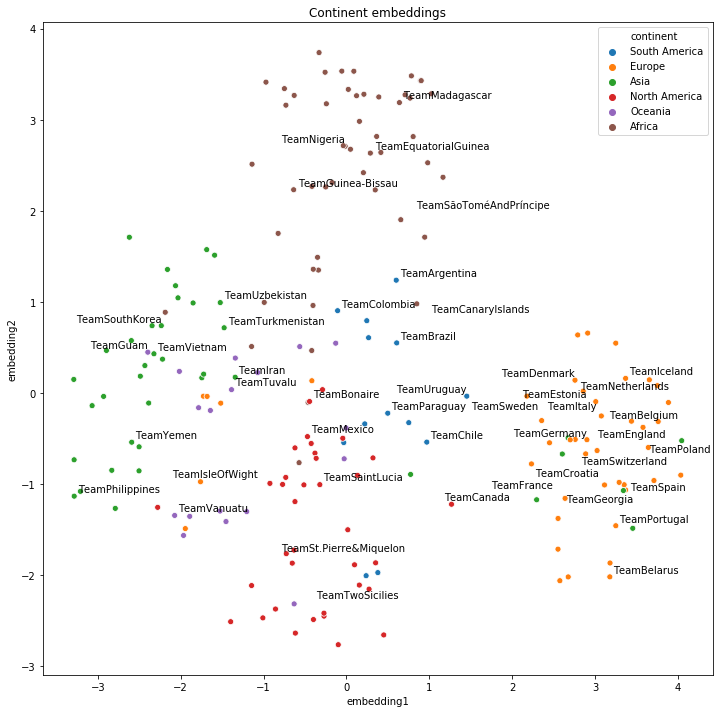

In [0]:
plot_clusters("continent")

We can see above that the embeddings learned geographical similarities even though this information was not explicit on the original dataset.

Now we plot the same 2D embeddings but with the clusters found by K-Means:

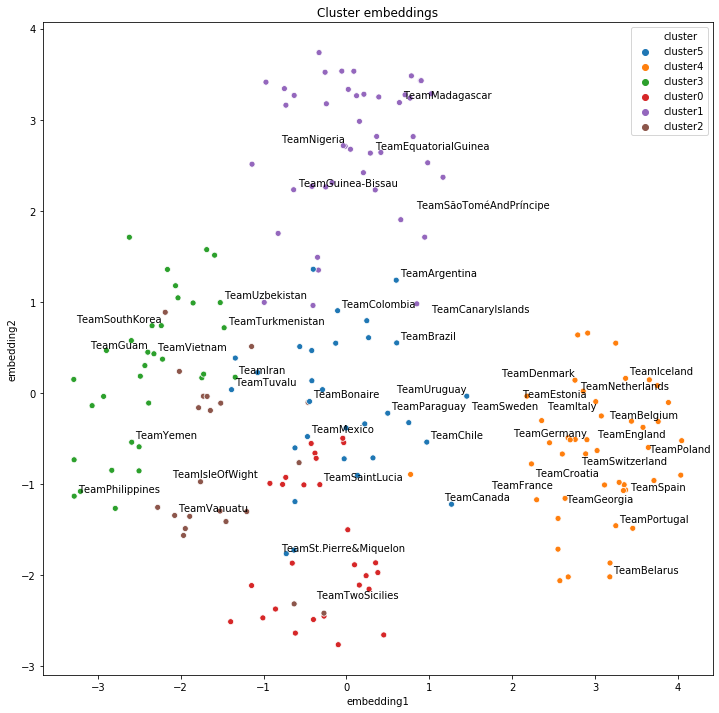

In [0]:
plot_clusters("cluster")

We can see that K-Means found very similar cluster to the natural geographical clusters by the continents. This shows that on the 200-dimensional embedding space, similar teams appear close together, which can be captured by a clustering algorithm.

Our evaluation of the clusters can be more objective by using a metric such as the [adjusted Rand score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html), which varies from -1 to 1, where 0 is random labelling and 1 is a perfect match:

In [0]:
from sklearn import metrics
metrics.adjusted_rand_score(plot_df.continent, plot_df.cluster)

0.3855256509991056

## Classification

We will use the knowledge embeddings to predict future matches as a classification problem.

We can model it as a multiclass problem with three classes: home team wins, home team loses, draw.

The embeddings are used directly as features to a XGBoost classifier.

First we need to determine the target:

In [0]:
df["results"] = (df.home_score > df.away_score).astype(int) + \
                (df.home_score == df.away_score).astype(int)*2 + \
                (df.home_score < df.away_score).astype(int)*3 - 1

In [0]:
df.results.value_counts(normalize=True)

0    0.486473
2    0.282456
1    0.231071
Name: results, dtype: float64

Now we create a function that extracts the features (knowledge embeddings for home and away teams) and the target for a particular subset of the dataset:

In [0]:
def get_features_target(mask):
    
    def get_embeddings(team):
        return team_embeddings.get(team, np.full(200, np.nan))
    
    X = np.hstack((np.vstack(df[mask].home_team_id.apply(get_embeddings).values),
                   np.vstack(df[mask].away_team_id.apply(get_embeddings).values)))
    y = df[mask].results.values
    return X, y

In [0]:
clf_X_train, y_train = get_features_target((df["train"]))
clf_X_test, y_test = get_features_target((~df["train"]))

In [0]:
clf_X_train.shape, clf_X_test.shape

((35714, 400), (5057, 400))

Note that we have 200 features by team because the ComplEx model uses imaginary and real number for its embeddings, so we have twice as many parameters as defined by `k=100` in its model definition.

We also have some missing information from the embeddings of the entities (i.e. teams) that only appear in the test set, which are unlikely to be correctly classified:

In [0]:
np.isnan(clf_X_test).sum()/clf_X_test.shape[1]

105.0

First install xgboost with `pip install xgboost`.

In [0]:
#%%capture
#!pip install xgboost
from xgboost import XGBClassifier

Create a multiclass model with 500 estimators:

In [0]:
clf_model = XGBClassifier(n_estimators=500, max_depth=5, objective="multi:softmax")

Fit the model using all of the training samples:

In [0]:
clf_model.fit(clf_X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

The baseline accuracy for this problem is 47%, as that is the frequency of the most frequent class (home team wins):

In [0]:
df[~df["train"]].results.value_counts(normalize=True)

0    0.471030
2    0.287325
1    0.241645
Name: results, dtype: float64

In [0]:
metrics.accuracy_score(y_test, clf_model.predict(clf_X_test))

0.527783270713862

In conclusion, while the baseline for this classification problem was 47%, with just the knowledge embeddings alone we were able to build a classifier that achieves **54%** accuracy.



---